# Bayesian A/B Testing
_Closed form computation for conversion and numeric tests._

In [1]:
# libraries
import pylab
import decimal
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import beta, gamma
from IPython.core.pylabtools import figsize

# import bayesian classes
from bayesian import bayesian_conversion_test, bayesian_numeric_test

In [2]:
########## generate simulated data ##########
np.random.seed(9)
figsize(12, 4)

N_A = 10000
N_B = 10000
true_p_A = 0.1 # group A conversion rate, 10%
true_p_B = 0.085 # group B conversion rate, 8.5%

# numeric
rev_A_EXP = np.random.exponential(scale = 5, size=int(N_A*true_p_A)) #group A rev, $5 ARPU expected value
rev_B_EXP = np.random.exponential(scale = 5.9, size=int(N_B*true_p_B)) #group B rev, $7 ARPU expected value

# conversions
conversions_A = stats.bernoulli.rvs(p = true_p_A, size=N_A)
conversions_B = stats.bernoulli.rvs(p = true_p_B, size=N_B)

# combine data into df
df_A = pd.DataFrame([['A']*N_A, rev_A_EXP]).T
df_A.columns = ['group', 'revenue']
df_A.fillna(0, inplace=True)
df_A['conversions'] = np.where(df_A.revenue == 0, 0, 1)

df_B = pd.DataFrame([['B']*N_B, rev_B_EXP]).T
df_B.columns = ['group', 'revenue']
df_B.fillna(0, inplace=True)
df_B['conversions'] = np.where(df_B.revenue == 0, 0, 1)

df = pd.concat([df_A, df_B])
df.reset_index(inplace=True, drop=True)
df

group   revenue  conversions
0         A  0.052142            1
1         A  3.484517            1
2         A  3.423646            1
3         A  0.718368            1
4         A  0.766403            1
...     ...       ...          ...
19995     B  0.000000            0
19996     B  0.000000            0
19997     B  0.000000            0
19998     B  0.000000            0
19999     B  0.000000            0

[20000 rows x 3 columns]

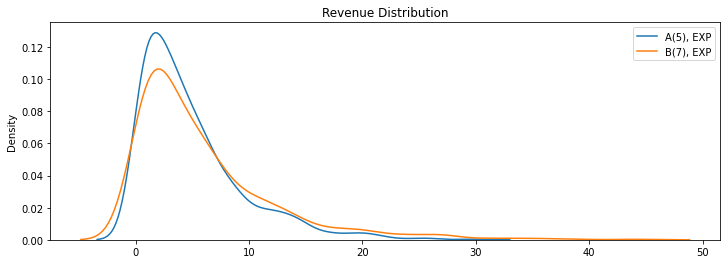

In [3]:
sns.kdeplot(df[(df.group=='A') & (df.revenue> 0)].revenue.values, label='A(5), EXP')
sns.kdeplot(df[(df.group=='B') & (df.revenue> 0)].revenue.values, label='B(7), EXP')
plt.title('Revenue Distribution')
plt.legend()
plt.show()

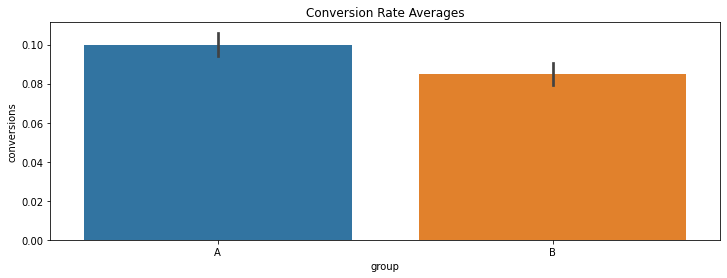

In [4]:
sns.barplot(x='group', y='conversions', data=df)
plt.title('Conversion Rate Averages')
plt.show()

In [5]:
df.to_csv('experiment_data.csv',header=True)

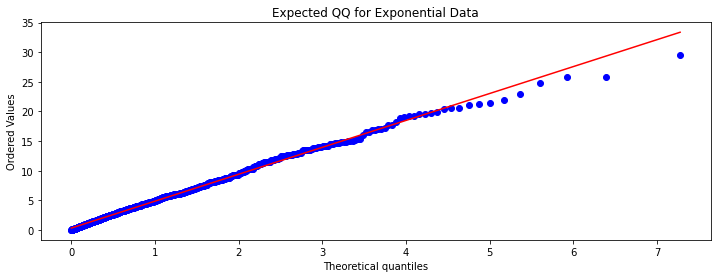

In [6]:
a_revenue = np.array(df[(df.group=='A') & (df.revenue>0)].revenue).astype('float')
stats.probplot(a_revenue, dist="expon", plot=pylab)
plt.title('Expected QQ for Exponential Data')
pylab.show()

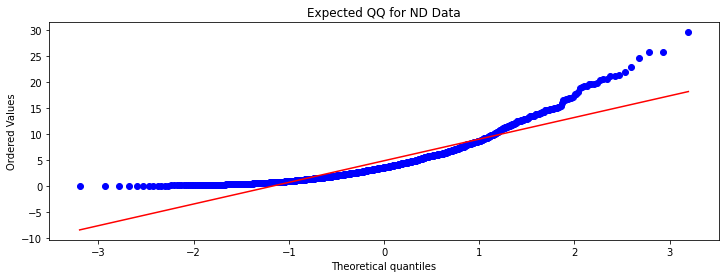

In [7]:
# confirming data is not ND
stats.probplot(a_revenue, dist="norm", plot=pylab)
plt.title('Expected QQ for ND Data')
pylab.show()

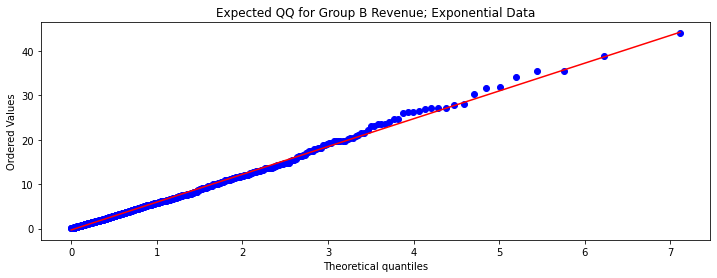

In [8]:
b_revenue = np.array(df[(df.group=='B') & (df.revenue!=0)].revenue).astype('float')
stats.probplot(b_revenue, dist="expon", plot=pylab)
plt.title('Expected QQ for Group B Revenue; Exponential Data')
pylab.show()

In [9]:
# summary statistics
summary = df.groupby(by=['group']).agg({'group': pd.Series.count, 'conversions': sum, 'revenue': sum})
summary.columns = ['cnt', 'conversions', 'revenue']
summary.reset_index(inplace=True)
summary['conversion_rate'] = summary.conversions/summary.cnt
summary['rev_per_conversion'] = summary.revenue/summary.conversions
summary.style.format({'conversion_rate': "{:.2%}"})

In [10]:
A_sum_rev = df[df.group=='A'].revenue.sum()
B_sum_rev = df[df.group=='B'].revenue.sum()

In [11]:
A_conversions = df[df.group=='A'].conversions
B_conversions = df[df.group=='B'].conversions
conversion = bayesian_conversion_test()
posterior_A, posterior_B, sim_posterior_A, sim_posterior_B = conversion.evaluate(df[df.group=='A'].conversions, 
                                                                                 df[df.group=='B'].conversions)

In [12]:
conversion.describe()

A Conversion Rate (%): 10.0000 
B Conversion Rate (%): 8.5000 
Relative Uplift (%): -15.00 

Modeled Posterior A Conversion Rate (%): 10.0088 
Modeled Posterior B Conversion Rate (%): 8.5061 
Prior CTR (%): None 
Probability B is better than A (%): 0.0 
Probability A is better than B (%): 100.0


In [13]:
numeric = bayesian_numeric_test()
a_posterior_dist_lambda, b_posterior_dist_lambda, a_simulation, b_simulation=numeric.evaluate(
                            A_conversions=df[df.group=='A'].conversions.values,
                            B_conversions=df[df.group=='B'].conversions.values,
                            A_metric=df[(df.group=='A') & (df.revenue>0)].revenue.values,
                            B_metric=df[(df.group=='B') & (df.revenue>0)].revenue.values,
                            A_prior_gamma_alpha=0.1, A_prior_gamma_scale=0.1, # weak priors for exponential
                            B_prior_gamma_alpha=0.1, B_prior_gamma_scale=0.1)

In [14]:
numeric.describe()

Actuals
A Avg Metric: 4.8517 
B Avg Metric: 5.9309 
Relative Uplift (%): 22.24 
Absolute Difference (%): 1.08 

Modeled
Modeled Exponential A Value (%): 4.8685 
Modeled Exponential B Value (%): 5.9484 
Probability B is better than A (%): 1.0 
Probability A is better than B (%): 0.0


In [15]:
print('a simulated posterior:', 1/a_simulation.mean().round(5), # 1/expected value of exp is the avg value of lambda posterior
      '\nb simulated posterior:', 1/b_simulation.mean().round(5))

a simulated posterior: 0.20540207456095305 
b simulated posterior: 0.16811243359558872


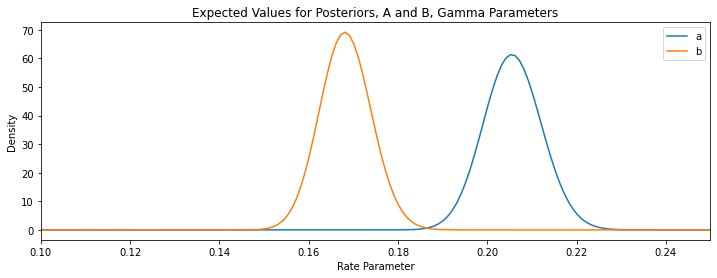

In [16]:
# plot credible intervals for posterior lambdas
fig, ax = plt.subplots()
x = np.linspace(0,1,1000)
a_post_lambda_interval = a_posterior_dist_lambda.pdf(x)
b_post_lambda_interval = b_posterior_dist_lambda.pdf(x)
ax.plot(x, a_post_lambda_interval, label='a')
ax.plot(x, b_post_lambda_interval, label='b')
ax.set_xlabel('Rate Parameter')
ax.set_ylabel('Density')
ax.set_title('Expected Values for Posteriors, A and B, Gamma Parameters')
plt.xlim(0.1,0.25)
ax.legend()
plt.show()

In [17]:
# chance b is better than a by at least 20%; this compares the expected values of the numeric metric
b_better_than_a_20_pct = [(i/j)-1>=0.2 for i,j in zip(b_simulation, a_simulation)]
np.mean(b_better_than_a_20_pct)

0.6475

In [18]:
# chance b is better than a by at least 10%; this compares the expected values of the numeric metric
b_better_than_a_10_pct = [(i/j)-1>=0.1 for i,j in zip(b_simulation, a_simulation)]
np.mean(b_better_than_a_10_pct)

0.987

Looks to be different gamma posterior parameters for treatment a and b. Since b is smaller, and the expected value of exponential likelihood = 1/gamma, looks like variant b might be better than a. But by how much?

We'll plot the distributions of revenue from both samples.

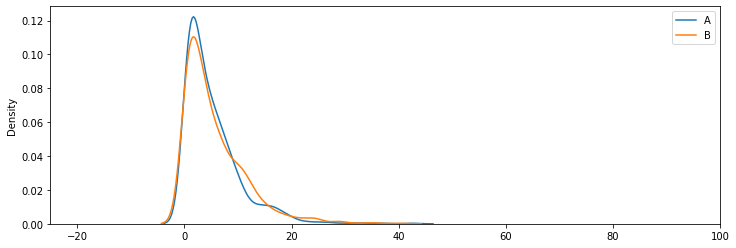

In [19]:
# plot simulated a and b revenue using posteriors

a_simulated_exponential = np.random.exponential(scale=a_simulation.mean(), size=1000) # scale is inverse of gamma para
b_simulated_exponential = np.random.exponential(scale=b_simulation.mean(), size=1000)

sns.kdeplot(a_simulated_exponential, label='A')
sns.kdeplot(b_simulated_exponential, label='B')
plt.xlim(-25,100)
plt.legend()
plt.show()

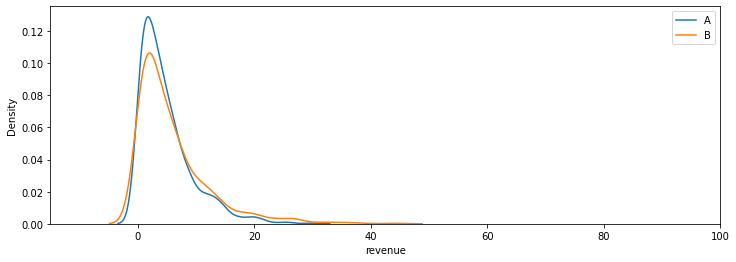

In [20]:
# compared to actual data
sns.kdeplot(df[(df.group=='A') & (df.revenue>0)].revenue, label='A')
sns.kdeplot(df[(df.group=='B') & (df.revenue>0)].revenue, label='B')
plt.xlim(-15, 100)
plt.legend()
plt.show()